<a href="https://colab.research.google.com/github/slipaway/melonplaylist/blob/%ED%98%84%EC%A3%BC/melon_kakao_word2vec_train%20n%20val_tag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

Cloning into 'khaiii'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 957 (delta 25), reused 49 (delta 19), pack-reused 877
Receiving objects: 100% (957/957), 33.03 MiB | 29.26 MiB/s, done.
Resolving deltas: 100% (383/383), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import timedelta, datetime
import glob
import os
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from collections import Counter
from typing import *
from khaiii import KhaiiiApi

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
folder = '/content/gdrive/My Drive/멜론 플레이리스트'
filelist = os.chdir(folder)

In [5]:
genre_gn_all=pd.read_json('genre_gn_all.json', typ='series')
train=pd.read_json('train.json')
val = pd.read_json('val.json')

In [ ]:
!git clone https://github.com/slipaway/melonplaylist.git

fatal: destination path 'melonplaylist' already exists and is not an empty directory.


# 0. 함수 정의

In [6]:
def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def uppertolower(string):
  if isEnglish(string) == True:
    string = string.lower() #태그나 제목이 영어로 들어간 경우, 모두 소문자로 바꿔주기

In [7]:
def re_sub(series: pd.Series) -> pd.Series:
  series = series.str.replace(pat=r'[ㄱ-ㅎ]', repl=r'', regex=True) #ㅋ 제거용
  series = series.str.replace(pat=r'[^\w\s]', repl=r'', regex=True) #특수문자 제거용
  series = series.str.replace(pat=r'[ ]{2,}', repl=r' ', regex=True) #공백 제거
  series = series.str.replace(pat=r'[\u3000]+', repl=r'', regex=True) #u3000제거
  return series

def flatten(list_of_list : List) -> List:
  flatten = [j for i in list_of_list for j in i]
  return flatten

def get_token(title: str, tokenizer)-> List[Tuple]:

  if len(title)==0 or title== ' ' : #제목이 공백인 경우 tokenizer 에러 발생
    return []
  
  result = tokenizer.analyze(title)
  result = [(morph.lex, morph.tag) for split in result for morph in split.morphs] # (형태소, 품사) 튜플의 리스트
  return result

def get_all_tags(df) -> List:
  tag_list = df['tags'].values.tolist()
  tag_list=flatten(tag_list)
  return tag_list

# 1. 태그 전처리

In [8]:
 train['tags'].head(10)

0                                                  [락]
1                                             [추억, 회상]
2                                            [까페, 잔잔한]
3    [연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...
4                                                 [댄스]
5    [운동, 드라이브, Pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...
6                          [짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]
7                                        [잔잔한, 추억, 회상]
8                          [일렉트로니카, 포크, 메탈, 락, 댄스, 인디]
9                   [록, Metal, 이일우, M에센셜, 메탈, Rock, 락]
Name: tags, dtype: object

In [9]:
#영어는 소문자로 모두 바꾸기
for i in range(len(train['tags'])):
  for j in range(len(train['tags'][i])):
    train['tags'][i][j]= train['tags'][i][j].lower()

In [10]:
tokenizer = KhaiiiApi()
all_tag = get_all_tags(train)
token_tag = [get_token(x, tokenizer) for x in all_tag] #태그를 형태소 분석

KeyboardInterrupt: ignored

In [ ]:
token_tag[:40]

[[('락', 'MAG')],
 [('추억', 'NNG')],
 [('회상', 'NNG')],
 [('까페', 'NNG')],
 [('잔잔', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')],
 [('연말', 'NNG')],
 [('눈', 'NNG'), ('오', 'VV'), ('는', 'ETM'), ('날', 'NNG')],
 [('캐럴', 'NNG')],
 [('분위기', 'NNG')],
 [('따듯', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')],
 [('크리스마스캐럴', 'NNG')],
 [('겨울', 'NNG'), ('노래', 'NNG')],
 [('크리스마스', 'NNG')],
 [('겨울왕국', 'NNG')],
 [('크리스마스', 'NNG'), ('송', 'MAG')],
 [('댄스', 'NNG')],
 [('운동', 'NNG')],
 [('드라이브', 'NNG')],
 [('pop', 'SL')],
 [('트로피컬', 'NNG'), ('하우스', 'NNG')],
 [('힐링', 'NNG')],
 [('기분', 'NNG'), ('전환', 'NNG')],
 [('2017', 'SN')],
 [('팝', 'NNG')],
 [('트렌', 'NNG'), ('드', 'NNP')],
 [('일렉', 'NNP')],
 [('짝사랑', 'NNG')],
 [('취향', 'NNG'), ('저격', 'NNG')],
 [('슬픔', 'NNG')],
 [('고백', 'NNG')],
 [('사랑', 'NNG')],
 [('이별', 'NNG')],
 [('잔잔', 'XR'), ('하', 'XSA'), ('ㄴ', 'ETM')],
 [('추억', 'NNG')],
 [('회상', 'NNG')],
 [('일렉트', 'NNP'), ('로', 'NNG'), ('니카', 'NNP')],
 [('포크', 'NNG')],
 [('메탈', 'NNG')],
 [('락', 'MAG')],
 [('댄스', 'NNG')]]

In [ ]:
token_itself=list(filter(lambda x: len(x)==1, token_tag)) # 태그 자체가 형태소여서 분리되지 않는 태그만 고름
token_itself=flatten(token_itself)
flatten_token=flatten(token_tag)

In [ ]:
print('%-23s'%'# of original tag is', f'{len(all_tag):8,}')
print('%-23s'%'# of morpheme itself is', f'{len(token_itself):8,}')
print('%-23s'%'# of total token is', f'{len(flatten_token):8,}')

# of original tag is     476,331
# of morpheme itself is  333,095
# of total token is      722,930


In [ ]:
#counting part of speech (pos)
pos=[x[1] for x in token_itself]
pos_count=Counter(pos)
popular_pos = pos_count.most_common()

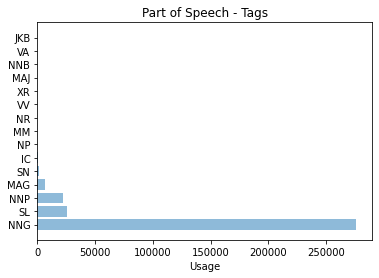

In [ ]:
#tag 분류표
objects=[x[0] for x in popular_pos]
y_pos=np.arange(len(objects))
performance=[x[1] for x in popular_pos]

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Usage')
plt.title('Part of Speech - Tags')
plt.show()

# 2. 플레이리스트 제목 전처리

In [ ]:
#플레이리스트 제목 형태소 분석

train['plylst_title']=re_sub(train['plylst_title'])
train.loc[:, 'ply_token']=train['plylst_title'].map(lambda x: get_token(x, tokenizer))

In [ ]:
using_pos=['NNG', 'SL', 'NNP', 'MAG', 'SN'] #일반 명사, 외국어, 고유 명사, 일반 부사, 숫자
train['ply_token']=train['ply_token'].map(lambda x: list(filter(lambda x: x[1] in using_pos, x)))


In [ ]:
unique_tag=set(token_itself)
unique_word=[x[0] for x in unique_tag]

#train 데이터의 plylst title 형태소 분리

In [ ]:
#정답 tag에 나온 형태소만 남겨두기
train['ply_token']=train['ply_token'].map(lambda x: list(filter(lambda x: x[0] in unique_word, x)))
train.head(10)

,tags,id,plylst_title,songs,like_cnt,updt_date,ply_token
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[(여행, NNG), (음악, NNG)]"
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[(요즘, NNG), (말, NNG)]"
2,"[까페, 잔잔한]",76951,편하게 잔잔하게 들을 수 있는 곡,"[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[(곡, NNG)]"
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"[(크리스마스, NNG), (분위기, NNG), (흠뻑, MAG)]"
4,[댄스],27616,추억의 노래,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"[(추억, NNG), (노래, NNG)]"
5,"[운동, 드라이브, pop, 트로피컬하우스, 힐링, 기분전환, 2017, 팝, 트렌...",69252,2017 Pop Trend,"[418694, 222305, 96545, 135950, 304687, 457451...",435,2017-09-15 15:59:26.000,"[(2017, SN)]"
6,"[짝사랑, 취향저격, 슬픔, 고백, 사랑, 이별]",45339,짝사랑고백사랑이별슬픔 감성을 자극하는곡들,"[528130, 505036, 398947, 627363, 37748, 376358...",24,2016-10-24 21:30:17.000,"[(짝사랑, NNG), (감성, NNG), (자극, NNG), (곡, NNG)]"
7,"[잔잔한, 추억, 회상]",36557,멍청이 내맘도 몰라,"[496913, 632529, 501426, 515574, 411161, 10341...",5,2008-09-23 22:32:02.000,"[(맘, NNG)]"
8,"[일렉트로니카, 포크, 메탈, 락, 댄스, 인디]",70741,DANCING IN THE MOONLIGHT 01,"[634861, 270738, 163936, 692209, 449477, 56342...",0,2019-11-30 21:17:59.000,"[(01, SN)]"
9,"[록, metal, 이일우, m에센셜, 메탈, rock, 락]",10288,록메탈 Written by 이일우,"[613315, 439294, 230806, 497932, 113479, 93506...",7,2016-06-17 18:23:54.000,"[(록메탈, NNP), (이일우, NNP)]"


# 3-1. 태그: word2vec 임베딩 with train dataset



In [116]:
from gensim.models import Word2Vec
tag_list = [train['tags'][i] for i in range(len(train['tags']))]
tag_embedding_model = Word2Vec(tag_list, window = 3, min_count=3, workers=4, iter=, sg=1)

KeyboardInterrupt: ignored

In [39]:
list(tag_embedding_model.wv.vocab.keys())

['락',
 '추억',
 '회상',
 '까페',
 '잔잔한',
 '연말',
 '눈오는날',
 '캐럴',
 '분위기',
 '따듯한',
 '크리스마스캐럴',
 '겨울노래',
 '크리스마스',
 '겨울왕국',
 '크리스마스송',
 '댄스',
 '운동',
 '드라이브',
 'pop',
 '트로피컬하우스',
 '힐링',
 '기분전환',
 '2017',
 '팝',
 '트렌드',
 '일렉',
 '짝사랑',
 '취향저격',
 '슬픔',
 '고백',
 '사랑',
 '이별',
 '일렉트로니카',
 '포크',
 '메탈',
 '인디',
 '록',
 'metal',
 'm에센셜',
 'rock',
 'kpop',
 '걸그룹댄스',
 '스트레스해소',
 '새해',
 '여행',
 '프로필음악',
 '카카오톡',
 '소원',
 '프로필',
 '소망',
 '다짐',
 '카톡',
 '듣고',
 '우울',
 '힘내',
 '힙합',
 '느낌있는',
 '밤',
 '새벽',
 'rnb',
 '감각적인',
 '국내',
 '그루브한',
 '가을',
 '재즈',
 '감성',
 '질리지않는',
 '나만알고싶은',
 '봄',
 '설렘',
 '비오는날',
 '스밍',
 '목록',
 '폐막식',
 '올림픽',
 '엑소',
 '조용히',
 '혼자',
 '새벽감성',
 '고민',
 '맥주한잔',
 '카페',
 'ost',
 '어쿠스틱',
 '편안한',
 '에너지',
 '듀엣',
 '달달',
 '피쳐링',
 '남녀',
 '신인',
 '국힙',
 '신나는',
 '존윌리엄스',
 '영화클래식',
 '겨울',
 '아침',
 '빅밴드',
 '상쾌한',
 '밝은',
 '스윙',
 '스윙재즈',
 '휴식',
 '여름',
 '매장음악',
 '헬스',
 '스포츠',
 '피트니스',
 '다이어트',
 '런닝',
 '필라테스',
 '산책',
 '요가',
 '발라드',
 '캐롤',
 '위로',
 '80년대',
 '90년대발라드',
 '올드송',
 '90년대',
 '옛날노래',
 '월드',
 '연주',
 '클럽',
 '스트레스',
 '주

예시.

In [24]:
tag_embedding_model.wv.most_similar('연말')

[('송년회', 0.49403804540634155),
 ('크리스마스송', 0.4437636435031891),
 ('연말감성', 0.4428122639656067),
 ('송년', 0.4266424775123596),
 ('겨울음악들', 0.4203534722328186),
 ('해피뉴이어', 0.411434531211853),
 ('신년', 0.41083043813705444),
 ('솔크', 0.40313130617141724),
 ('겨울노래베스트', 0.39827805757522583),
 ('겨울분위기', 0.3957612216472626)]

In [21]:
tag_embedding_model.wv.most_similar('조용')

[('아쿠스틱', 0.4819701611995697),
 ('진정', 0.4786207377910614),
 ('은은', 0.46720558404922485),
 ('조용함', 0.46004608273506165),
 ('우울함은', 0.4505477547645569),
 ('학습', 0.445264995098114),
 ('한적', 0.4433886408805847),
 ('생각이', 0.44096094369888306),
 ('자기_전', 0.43747133016586304),
 ('우울할', 0.43700551986694336)]

In [128]:
tag_embedding_model.wv.most_similar(positive = ['감성','기분전환'])

[('다운', 0.3612802028656006),
 ('추천힙합', 0.3569207191467285),
 ('비오느날', 0.3414692282676697),
 ('소개글', 0.3412639796733856),
 ('하늘하늘', 0.3398924171924591),
 ('칠음악', 0.3287751078605652),
 ('핫한노래', 0.325528085231781),
 ('봄의시작', 0.3253491520881653),
 ('아티스트갤러리', 0.3252103328704834),
 ('매일듣는', 0.32257160544395447)]

#4-1. 곡: word2vec 임베딩 with train dataset

In [ ]:
train['songs']

0         [525514, 129701, 383374, 562083, 297861, 13954...
1         [432406, 675945, 497066, 120377, 389529, 24427...
2         [83116, 276692, 166267, 186301, 354465, 256598...
3         [394031, 195524, 540149, 287984, 440773, 10033...
4         [159327, 553610, 5130, 645103, 294435, 100657,...
                                ...                        
115066    [429629, 441511, 612106, 516359, 691768, 38714...
115067    [321330, 216057, 534472, 240306, 331098, 23288...
115068    [50512, 249024, 250608, 371171, 229942, 694943...
115069    [533534, 608114, 343608, 417140, 609009, 30217...
115070    [26008, 456354, 324105, 89871, 135272, 143548,...
Name: songs, Length: 115071, dtype: object

In [ ]:
#integer를 string으로 바꿔주기
for i in range(len(train['songs'])):
  for j in range(len(train['songs'][i])):
    train['songs'][i][j]= str(train['songs'][i][j])

In [ ]:
song_list = [train['songs'][i] for i in range(len(train['songs']))]

In [ ]:
beta = song_list[:50000]

In [ ]:
from gensim.test.utils import get_tmpfile
from gensim.models.callbacks import CallbackAny2Vec

In [ ]:
class EpochSaver(CallbackAny2Vec):
...     '''Callback to save model after each epoch.'''
...
...     def __init__(self, path_prefix):
...         self.path_prefix = path_prefix
...         self.epoch = 0
...
...     def on_epoch_end(self, model):
...         output_path = get_tmpfile('{}_epoch{}.model'.format(self.path_prefix, self.epoch))
...         model.save(output_path)
...         self.epoch += 1

class EpochLogger(CallbackAny2Vec):
     def __init__(self):
         self.epoch = 0

     def on_epoch_begin(self, model):
         print("Epoch #{} start".format(self.epoch))

     def on_epoch_end(self, model):
         print("Epoch #{} end".format(self.epoch))
         self.epoch += 1

In [ ]:
from gensim.models import Word2Vec
epoch_logger = EpochLogger()
song_embedding_model = Word2Vec(beta, size=160, window = 3, min_count=2, workers=4, iter=200, sg=1, callbacks=[epoch_logger])

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end
Epoch #10 start
Epoch #10 end
Epoch #11 start
Epoch #11 end
Epoch #12 start
Epoch #12 end
Epoch #13 start
Epoch #13 end
Epoch #14 start
Epoch #14 end
Epoch #15 start
Epoch #15 end
Epoch #16 start
Epoch #16 end
Epoch #17 start
Epoch #17 end
Epoch #18 start
Epoch #18 end
Epoch #19 start
Epoch #19 end
Epoch #20 start
Epoch #20 end
Epoch #21 start
Epoch #21 end
Epoch #22 start
Epoch #22 end
Epoch #23 start
Epoch #23 end
Epoch #24 start
Epoch #24 end
Epoch #25 start
Epoch #25 end
Epoch #26 start
Epoch #26 end
Epoch #27 start
Epoch #27 end
Epoch #28 start
Epoch #28 end
Epoch #29 start
Epoch #29 end
Epoch #30 start
Epoch #30 end
Epoch #31 start
Epoch #31 end
Epoch #32 start
Epoch #32 end
Epoch #33 start
Epoch #33 end


In [ ]:
list(song_embedding_model.wv.vocab.keys())

['525514',
 '129701',
 '383374',
 '562083',
 '297861',
 '139541',
 '351214',
 '650298',
 '531057',
 '205238',
 '706183',
 '127099',
 '660493',
 '461973',
 '121455',
 '72552',
 '223955',
 '324992',
 '50104',
 '432406',
 '675945',
 '497066',
 '120377',
 '389529',
 '244277',
 '461062',
 '696302',
 '442765',
 '532114',
 '586541',
 '33389',
 '244000',
 '692078',
 '37741',
 '645653',
 '571802',
 '200183',
 '61435',
 '204499',
 '41749',
 '129258',
 '413920',
 '117205',
 '6546',
 '152422',
 '602724',
 '425946',
 '173634',
 '631268',
 '409869',
 '97749',
 '395416',
 '103741',
 '181101',
 '472144',
 '414721',
 '75801',
 '315216',
 '192882',
 '383960',
 '548636',
 '83116',
 '276692',
 '166267',
 '186301',
 '354465',
 '256598',
 '233195',
 '666852',
 '686560',
 '556426',
 '142974',
 '331878',
 '195141',
 '32017',
 '617795',
 '396532',
 '623704',
 '516930',
 '300104',
 '176874',
 '443513',
 '471385',
 '35784',
 '153029',
 '336743',
 '203558',
 '348801',
 '454550',
 '394031',
 '195524',
 '540149',
 

예시.

In [ ]:
song_embedding_model.wv.most_similar('108757') #그렇게 너를 사랑해 - 자전거 탄 풍경 / 포크.블루스

[('628431', 0.7377691268920898),
 ('67474', 0.6897634267807007),
 ('212848', 0.688234269618988),
 ('643244', 0.686432957649231),
 ('552882', 0.6733667254447937),
 ('491059', 0.67307049036026),
 ('493812', 0.6671214699745178),
 ('637774', 0.666467547416687),
 ('284771', 0.6626992225646973),
 ('560654', 0.6562246680259705)]

In [ ]:
song_embedding_model.wv.most_similar('700444') #둘이 하나(Love Theme) - 린 / OST, 발라드

[('435412', 0.7547087669372559),
 ('129107', 0.7500742673873901),
 ('482928', 0.7471587061882019),
 ('133812', 0.7380530834197998),
 ('707093', 0.7288321256637573),
 ('231256', 0.7260942459106445),
 ('281640', 0.725249171257019),
 ('106338', 0.7123962044715881),
 ('551177', 0.7109552621841431),
 ('516676', 0.7103385925292969)]

In [ ]:
song_embedding_model.wv.most_similar('109526') #선인장 - 에피톤 프로젝트

[('167736', 0.6181034445762634),
 ('328256', 0.5800551176071167),
 ('531711', 0.5799998044967651),
 ('361043', 0.5776767730712891),
 ('239991', 0.5656557083129883),
 ('683821', 0.5554535388946533),
 ('43873', 0.5509897470474243),
 ('123354', 0.5484097003936768),
 ('479749', 0.5436295866966248),
 ('317004', 0.5432959198951721)]

# Validation

In [ ]:
val.head(10)

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[],118598,,"[373313, 151080, 275346, 696876, 165237, 52593...",1675,2019-05-27 14:14:33.000
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000
2,[],51464,,"[529437, 516103, 360067, 705713, 226062, 37089...",62,2008-06-21 23:26:22.000
3,[],45144,,"[589668, 21711, 570151, 320043, 13930, 599327,...",20,2017-10-30 18:15:43.000
4,[],79929,,"[672718, 121924, 102694, 683657, 201558, 38511...",20,2017-02-07 11:40:42.000
5,"[비, 분위기, 컨트리, 서정적인]",138538,,"[173033, 138237, 63140, 15733, 461780, 308519,...",2,2019-06-12 17:43:35.000
6,[],127575,,"[227044, 424672, 515592, 22408, 57893, 153714,...",2,2011-10-28 11:21:51.000
7,[],115317,,"[54457, 423722, 337682, 91214, 644980, 556444,...",3,2014-01-26 20:00:30.000
8,[스트레스],80810,리듬타면서 빡시게 운동하자!!!(스트레스 날리자):},[],127,2017-02-09 17:33:45.000
9,[],142007,기분 좋은 재즈와 함께 만드는 달달한 하루,[],0,2015-06-22 09:11:02.000


# 태그 예측하기

# i) 본래 있는 태그를 활용해서 예측

In [184]:
#태그가 있는 플레이리스트 인덱스 뽑아내기
tag_yu_index = []
tag_no_index = []
for i in range(len(val['tags'])):
  if len(val['tags'][i]) != 0:
    tag_yu_index.append(i)
  else:
    tag_no_index.append(i)

In [185]:
val_tag_yu = val.loc[tag_yu_index,:]
val_tag_yu = val_tag_yu.reset_index() #index reset
val_tag_yu.head(10)

,index,tags,id,plylst_title,songs,like_cnt,updt_date
0,5,"[비, 분위기, 컨트리, 서정적인]",138538,,"[173033, 138237, 63140, 15733, 461780, 308519,...",2,2019-06-12 17:43:35.000
1,8,[스트레스],80810,리듬타면서 빡시게 운동하자!!!(스트레스 날리자):},[],127,2017-02-09 17:33:45.000
2,11,"[아침, 눈, 크리스마스]",136650,,"[174132, 257367, 539802, 568691, 296891, 38471...",6,2017-11-24 11:26:05.000
3,12,[EDM],53131,,"[392257, 668879, 460746, 680240, 490966, 25010...",268,2016-09-19 15:40:31.000
4,17,[생각나],2380,다시 생각나는 그 사람,[],6,2016-03-19 23:53:20.000
5,20,"[피아노, 이루마, 메로디]",149069,불면증엔 아름다운 뉴에이지 곡들,[],11,2019-12-15 19:15:21.000
6,21,"[상큼한, 출근길, 트렌디, 팝, 신나는]",7373,,"[534729, 149593, 677181, 179617, 408079, 34339...",73,2019-12-17 15:47:59.000
7,23,[발렌타인데이],29647,,"[498353, 283397, 588606, 499171, 191963, 46258...",19,2017-02-12 22:25:12.000
8,24,"[이별이_다가올때, 새벽감성, 감성변태]",105642,,"[454528, 501713, 116573, 698058, 118049, 64579...",3,2018-04-10 11:57:20.000
9,25,"[테크노, 클럽, 페스티벌, 트렌디, 댄스]",41619,,"[672170, 63460, 422281, 230796, 681893, 342471...",1,2019-10-16 03:06:37.000


In [186]:
val_tag_list = [val_tag_yu['tags'][i] for i in range(len(val_tag_yu['tags']))]

a) train에서 학습하지 못한 tag는 제외 (하나라도 없으면 제외시킴)

In [187]:
index_list = []
for i in range(len(val_tag_list)):
  for j in range(len(val_tag_list[i])):
    if val_tag_list[i][j] not in list(tag_embedding_model.wv.vocab.keys()):
      index_list.append(i)
index_list = set(index_list)
index_list = list(index_list)

In [188]:
index_list.sort()
index_list #train에 없는 tag index

[3,
 5,
 8,
 11,
 28,
 33,
 42,
 50,
 51,
 52,
 55,
 60,
 69,
 75,
 77,
 85,
 86,
 88,
 97,
 99,
 100,
 102,
 104,
 126,
 128,
 139,
 141,
 156,
 166,
 173,
 176,
 177,
 184,
 190,
 193,
 200,
 207,
 208,
 211,
 213,
 229,
 232,
 236,
 239,
 241,
 243,
 244,
 246,
 252,
 259,
 266,
 272,
 274,
 279,
 282,
 283,
 291,
 297,
 298,
 309,
 311,
 313,
 321,
 328,
 329,
 330,
 332,
 338,
 339,
 340,
 341,
 349,
 354,
 359,
 361,
 370,
 375,
 418,
 421,
 422,
 435,
 440,
 443,
 444,
 447,
 451,
 454,
 461,
 462,
 469,
 473,
 489,
 493,
 506,
 511,
 516,
 531,
 541,
 546,
 559,
 565,
 568,
 570,
 574,
 576,
 577,
 578,
 581,
 588,
 589,
 590,
 591,
 593,
 597,
 601,
 607,
 615,
 616,
 619,
 620,
 621,
 624,
 626,
 646,
 650,
 651,
 679,
 704,
 707,
 708,
 709,
 725,
 726,
 740,
 745,
 748,
 750,
 751,
 752,
 755,
 759,
 768,
 769,
 770,
 777,
 781,
 787,
 788,
 791,
 797,
 800,
 803,
 806,
 817,
 819,
 820,
 822,
 824,
 826,
 836,
 842,
 844,
 855,
 858,
 863,
 868,
 871,
 881,
 884,
 889,
 89

In [201]:
list_for_list = []
val_predicted_tag = []
for i in range(len(val_tag_list)):
  if i in index_list:
    val_predicted_tag.append([])
  else:
    for j in range(10):
      list_for_list.append(tag_embedding_model.wv.most_similar(positive = val_tag_list[i])[j][0])
    val_predicted_tag.append(list_for_list)
    list_for_list = []

In [202]:
val_tag_yu['predicted_tags']=val_predicted_tag

In [203]:
val_tag_yu.head(10)

,index,tags,id,plylst_title,songs,like_cnt,updt_date,predicted_tags
0,5,"[비, 분위기, 컨트리, 서정적인]",138538,,"[173033, 138237, 63140, 15733, 461780, 308519,...",2,2019-06-12 17:43:35.000,"[21세기, 가을에어울리는, 전통포크, 컨트리록, 오후의, 빈자리, 파두, 평생소장..."
1,8,[스트레스],80810,리듬타면서 빡시게 운동하자!!!(스트레스 날리자):},[],127,2017-02-09 17:33:45.000,"[비트있는, 박력, 국내edm, 비키니, 불금에, 빡센, 하드코어, 시원시원, 헬스..."
2,11,"[아침, 눈, 크리스마스]",136650,,"[174132, 257367, 539802, 568691, 296891, 38471...",6,2017-11-24 11:26:05.000,"[캐롤송, christmas, 캐롤, 겨울음악들, carol, xmas, 화이트크리..."
3,12,[EDM],53131,,"[392257, 668879, 460746, 680240, 490966, 25010...",268,2016-09-19 15:40:31.000,[]
4,17,[생각나],2380,다시 생각나는 그 사람,[],6,2016-03-19 23:53:20.000,"[미안함, 이별후에_들으면_공감되는노래, 아프다, 리수, 생각이나, 슬픈힙합, 가슴..."
5,20,"[피아노, 이루마, 메로디]",149069,불면증엔 아름다운 뉴에이지 곡들,[],11,2019-12-15 19:15:21.000,[]
6,21,"[상큼한, 출근길, 트렌디, 팝, 신나는]",7373,,"[534729, 149593, 677181, 179617, 408079, 34339...",73,2019-12-17 15:47:59.000,"[자라, 소개글, 개신남, 가벼운노래, 맑고, 등굣길, 탄산, 통근, 아이셔, 국내..."
7,23,[발렌타인데이],29647,,"[498353, 283397, 588606, 499171, 191963, 46258...",19,2017-02-12 22:25:12.000,"[달달송, 고백노래, 초콜렛, 설렘가득, 사랑음악, 초콜릿, 연애의발견, 밀당, 썸..."
8,24,"[이별이_다가올때, 새벽감성, 감성변태]",105642,,"[454528, 501713, 116573, 698058, 118049, 64579...",3,2018-04-10 11:57:20.000,[]
9,25,"[테크노, 클럽, 페스티벌, 트렌디, 댄스]",41619,,"[672170, 63460, 422281, 230796, 681893, 342471...",1,2019-10-16 03:06:37.000,"[월클돔, edc, 국내edm, 하드스타일, 보컬있는이디엠, 5tardium, 불목..."


b) 하나라도 train에 있는 것

# 곡 예측하기
i) 플레이리스트에 곡이 있는 경우

In [ ]:
#곡이 있는 플레이리스트 인덱스 뽑아내기
song_yu_index = []
song_no_index = []
for i in range(len(val['songs'])):
  if len(val['songs'][i]) != 0:
    song_yu_index.append(i)
  else:
    song_no_index.append(i)

In [ ]:
#노래 있는 경우
val_song_yu = val.loc[song_yu_index,:]

In [ ]:
val_song_yu['songs']

0        [373313, 151080, 275346, 696876, 165237, 52593...
2        [529437, 516103, 360067, 705713, 226062, 37089...
3        [589668, 21711, 570151, 320043, 13930, 599327,...
4        [672718, 121924, 102694, 683657, 201558, 38511...
5        [173033, 138237, 63140, 15733, 461780, 308519,...
                               ...                        
23010    [75842, 26083, 244183, 684715, 500593, 508608,...
23011    [450275, 487671, 561031, 663944, 628672, 59121...
23012    [625875, 464051, 11657, 236393, 358186, 213435...
23013    [161094, 665833, 688145, 432735, 439938, 12665...
23014    [643070, 132994, 98223, 293236, 513129, 650494...
Name: songs, Length: 18636, dtype: object

ii) 플레이리스트에 곡이 없는 경우: 태그, 플레이리스트 제목 가지고 곡 뽑아내야 하는데...

In [ ]:
val_song_no = val.loc[song_no_index,:]
val_song_no

,tags,id,plylst_title,songs,like_cnt,updt_date
1,[],131447,앨리스테이블,[],1,2014-07-16 15:24:24.000
8,[스트레스],80810,리듬타면서 빡시게 운동하자!!!(스트레스 날리자):},[],127,2017-02-09 17:33:45.000
9,[],142007,기분 좋은 재즈와 함께 만드는 달달한 하루,[],0,2015-06-22 09:11:02.000
17,[생각나],2380,다시 생각나는 그 사람,[],6,2016-03-19 23:53:20.000
20,"[피아노, 이루마, 메로디]",149069,불면증엔 아름다운 뉴에이지 곡들,[],11,2019-12-15 19:15:21.000
...,...,...,...,...,...,...
22991,[],32537,컨트리 황제 조니 캐시가 선 레코드 시절 발표한 초기 대표작,[],28,2019-06-17 14:22:48.000
22992,[사랑],32812,♥옷차림이 가벼워질때 부담없이 듣는음악♥,[],8,2015-05-08 00:09:01.000
22996,[],86721,해 저무는 밤,[],5,2016-04-27 15:32:55.000
23002,"[텐션, 명곡, 학창시절, 텐션업]",56570,숨어듣는명곡! 텐션올릴때듣는 그시절그노래!! (그냥명곡있을수있음주의),[],538,2020-04-18 22:02:07.000
